In [1]:
import numpy as np
import cv2, glob, time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
from utils.utils import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

# Read dataset

In [2]:
cars = glob.glob('input/train/vehicles/**/*.jpeg')
notcars = glob.glob('input/train/non-vehicles/**/*.jpeg')
print("Number of vehicles:", len(cars))
print("Number of non-vehicles:", len(notcars))

Number of vehicles: 1196
Number of non-vehicles: 1125


# Extract features

In [3]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hog_feat = True # HOG features on or off

In [4]:
# Car features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=None, hist_bins=None, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=None, 
                        hist_feat=None, hog_feat=hog_feat)
#Non-Car features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=None, hist_bins=None, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=None, 
                        hist_feat=None, hog_feat=hog_feat)

# Define the train vector
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

/usr/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


# Train a classifier

In [5]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 972
0.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9957


/usr/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


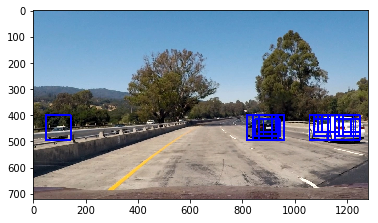

In [7]:
rects = []
img = mpimg.imread('test_images/test1.jpg')
draw_img = np.copy(img)
rects = rects + find_cars(img, 400, 500, 1.0, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block,False)
rects = rects + find_cars(img, 400, 540, 1.5, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block,False)
rects = rects + find_cars(img, 500, 600, 1.0, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block,False)
rects = rects + find_cars(img, 500, 640, 1.5, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block,False)
out_img = draw_boxes(draw_img, rects, color=(0,0,255), thick=6) 
plt.imshow(out_img)

In [16]:
plt.figure(figsize=(10,10))
    
def process_image(image):
    draw = np.copy(image)
    rectangles = []
    rectangles = rectangles + find_cars(image, 400, 500, 1.0, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles = rectangles + find_cars(image, 400, 540, 1.5, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles = rectangles + find_cars(image, 500, 600, 1.0, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block) 
    rectangles = rectangles + find_cars(image, 500, 640, 1.5, svc, color_space ,X_scaler, orient, pix_per_cell, cell_per_block) 
    heat = add_heat(np.zeros_like(image[:,:,0]), rectangles)
    heat = apply_threshold(heat, 0)
    labels = label(heat)
    out_img = draw_labeled_bboxes(draw, labels)
    #out_img = draw_boxes(draw, rectangles, color=(0,0,255), thick=6) 
    return out_img

# Test on images

In [17]:
print("Found", len(glob.glob('test_images/*.jpg')), "test images")

Found 10 test images


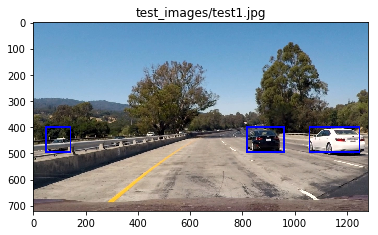

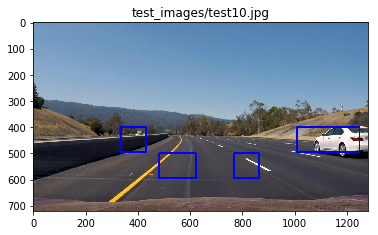

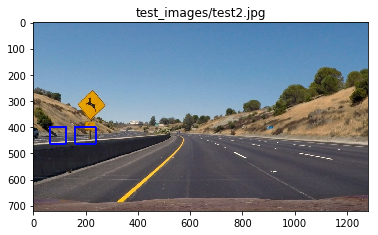

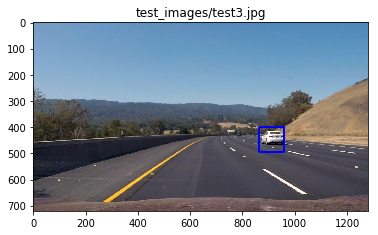

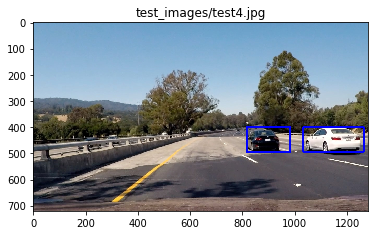

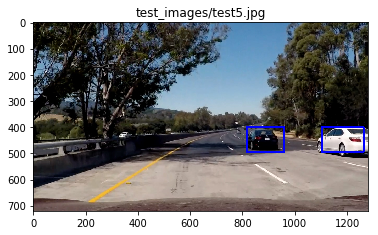

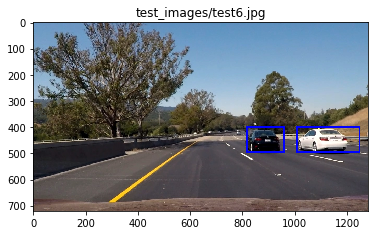

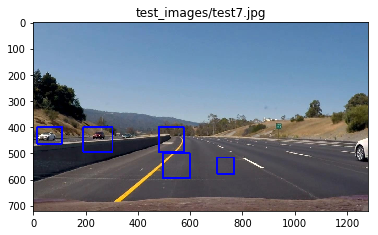

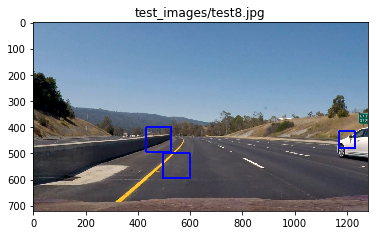

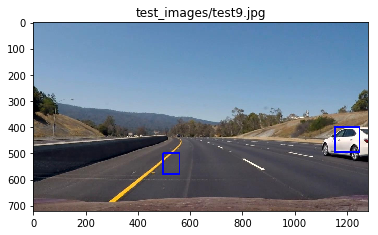

In [18]:
for test_img in sorted(glob.glob('test_images/*.jpg')): 
    img = mpimg.imread(test_img)
    out_img = process_image(img)
    plt.title(test_img)
    plt.imshow(out_img)
    plt.show()

# Test on video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
video_output = 'output_videos/vehicle_detection_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)